In [23]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pickle
import os
import gensim # ### THÊM MỚI ### Để tải FastText

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, GRU, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau # ### THÊM MỚI ### (Nên giữ lại từ phiên bản cải thiện trước)
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam # ### THÊM MỚI ### (Nên giữ lại)
from sklearn.utils import class_weight # ### THÊM MỚI ### (Nên giữ lại)

In [24]:
# --- 0. Configuration ---
DATA_FILE = r'E:\LEARN_5\XuLyNgonNguTuNhien\project\data\cleaned_data.csv'
# Tạo thư mục mới cho mô hình dùng Word2Vec
MODEL_SAVE_DIR = r'E:\LEARN_5\XuLyNgonNguTuNhien\project\models_word2vec'
TOKENIZER_PATH = f'{MODEL_SAVE_DIR}/tokenizer.pkl'
LABEL_ENCODER_PATH = f'{MODEL_SAVE_DIR}/label_encoder.pkl'
MAX_LEN_PATH = f'{MODEL_SAVE_DIR}/max_len.pkl'
BIGRU_MODEL_PATH = f'{MODEL_SAVE_DIR}/bigru_model.keras'
BILSTM_MODEL_PATH = f'{MODEL_SAVE_DIR}/bilstm_model.keras'

# ### THÊM MỚI ###: Đường dẫn đến file pre-trained FastText (ví dụ: cc.vi.300.vec)
# THAY ĐỔI ĐƯỜNG DẪN NÀY CHO PHÙ HỢP VỚI MÁY CỦA BẠN
PRETRAINED_FASTTEXT_PATH = r'E:\LEARN_5\XuLyNgonNguTuNhien\project\models\cc.vi.300.bin' # HOẶC TÊN FILE KHÁC CỦA BẠN
EMBEDDING_DIM_PRETRAINED = 300  # Chiều của FastText vectors (thường là 300)

# Model Hyperparameters - Điều chỉnh nếu cần
MAX_WORDS = 15000          # Giữ nguyên hoặc tăng nếu từ vựng lớn
MAX_LEN_PERCENTILE = 95    # Xác định MAX_LEN dựa trên phân vị này
GRU_UNITS = 128
LSTM_UNITS = 128
EPOCHS = 30                # Có thể cần ít epochs hơn khi dùng pre-trained embeddings
BATCH_SIZE = 32
LEARNING_RATE = 1e-3       # Tốc độ học ban đầu
DROPOUT_RATE = 0.4
TRAIN_EMBEDDINGS = False   # ### THÊM MỚI ###: True để tinh chỉnh, False để giữ nguyên pre-trained


In [25]:
# --- 1. Load and Preprocess Data ---
df_original = pd.read_csv(DATA_FILE)
df = df_original.copy()
print("5 dòng dữ liệu đầu tiên (gốc):")
print(df.head())

df.dropna(subset=['text', 'Topic'], inplace=True)
print(f"\nSố lượng mẫu sau khi loại bỏ NaN: {len(df)}")

5 dòng dữ liệu đầu tiên (gốc):
                                                text Topic
0  công_cụ trí_tuệ_nhân_tạo hữu_dụng chatgpt cạnh...    AI
1  figure_trí tuệ nhân_tạo công_ty robot hình mỹ ...    AI
2  ceo microsoft trí_tuệ_nhân_tạo đảm_nhiệm viết ...    AI
3  trí_tuệ_nhân_tạo grok musk trả_lời internet el...    AI
4  openai xác_nhận chatgpt nịnh_hót openai chatgp...    AI

Số lượng mẫu sau khi loại bỏ NaN: 16003



--- Phân tích số lượng mẫu theo chủ đề ---
Số lượng mẫu theo chủ đề TRƯỚC KHI lọc thủ công:
Topic
Giáo dục 4.0               449
Người Việt 5 châu          448
Giải trí giới sao          444
Việc làm                   443
Tin tức sức khoẻ           443
Giải trí nhạc              441
Giải trí phim              440
Ebank                      440
Dân sinh                   439
Sống khoẻ                  439
Bóng đá                    438
Giao thông                 438
Chính trị                  437
Các môn thể thao khác      436
Quân sự                    434
Hậu trường thể thao        432
Kinh doanh quốc tế         430
Nhịp sống                  428
AI                         428
Thiết bị                   427
Giải trí thời trang        426
Vũ trụ                     422
Tin tức Giáo dục           421
Sân khấu mỹ thuật          419
Chuyển đổi số              417
Thị trường xe              416
Hàng hóa                   414
Ẩm thực                    404
Tổ ấm                      404
Ch

C:\Users\Mai Xuan Truong\AppData\Local\Temp\ipykernel_7508\4240542688.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=topic_counts.index, y=topic_counts.values, palette="viridis")


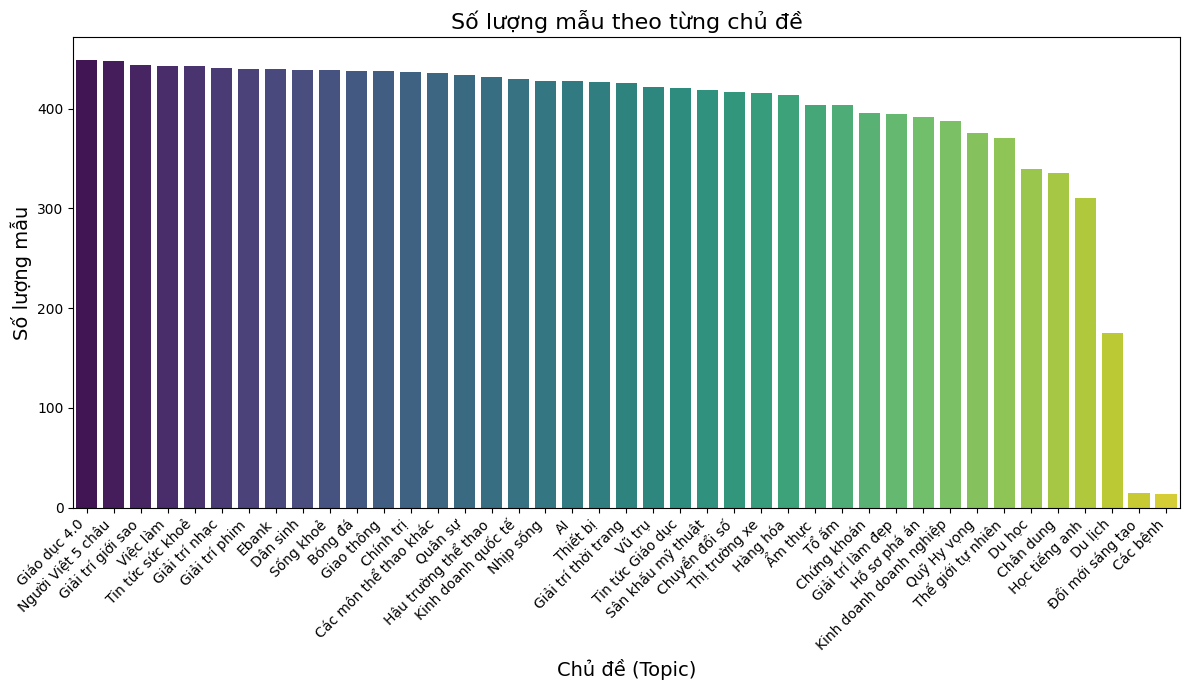

In [26]:
# --- 1.1. Phân tích số lượng mẫu theo chủ đề và cho phép loại bỏ thủ công ---
print("\n--- Phân tích số lượng mẫu theo chủ đề ---")
topic_counts = df['Topic'].value_counts()
print("Số lượng mẫu theo chủ đề TRƯỚC KHI lọc thủ công:")
print(topic_counts)

# Vẽ biểu đồ cột
plt.figure(figsize=(12, 7))
sns.barplot(x=topic_counts.index, y=topic_counts.values, palette="viridis")
plt.title('Số lượng mẫu theo từng chủ đề', fontsize=16)
plt.xlabel('Chủ đề (Topic)', fontsize=14)
plt.ylabel('Số lượng mẫu', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

In [27]:
TOPICS_TO_REMOVE = ["Du lịch", "Đổi mới sáng tạo", "Các bệnh"] # Keep this or modify as needed
df_filtered = df.copy()
if TOPICS_TO_REMOVE:
    print(f"\nCác chủ đề được chọn để loại bỏ thủ công: {', '.join(TOPICS_TO_REMOVE)}")
    actual_topics_to_remove = [topic for topic in TOPICS_TO_REMOVE if topic in df_filtered['Topic'].unique()]
    if not actual_topics_to_remove:
        print("Không có chủ đề nào trong danh sách cần loại bỏ tồn tại trong dữ liệu hiện tại.")
    else:
        print(f"Các chủ đề thực sự sẽ bị loại bỏ: {', '.join(actual_topics_to_remove)}")
        df_filtered = df_filtered[~df_filtered['Topic'].isin(actual_topics_to_remove)].copy()
        removed_count_manual = len(df) - len(df_filtered)
        print(f"Đã loại bỏ {removed_count_manual} mẫu thuộc các chủ đề trên.")
else:
    print("\nKhông có chủ đề nào được chọn để loại bỏ thủ công.")

print("\nSố lượng mẫu theo chủ đề SAU KHI lọc thủ công:")
if not df_filtered.empty:
    print(df_filtered['Topic'].value_counts())
    print(f"Tổng số lượng mẫu còn lại: {len(df_filtered)}")
else:
    print("Không còn mẫu nào sau khi lọc chủ đề.")

if df_filtered.empty:
    print("\nKhông còn dữ liệu sau khi lọc chủ đề. Dừng chương trình.")
    exit()
if df_filtered['Topic'].nunique() < 2:
    print(f"\nChỉ còn {df_filtered['Topic'].nunique()} chủ đề sau khi lọc. Cần ít nhất 2 chủ đề để phân loại. Dừng chương trình.")
    exit()

df = df_filtered


Các chủ đề được chọn để loại bỏ thủ công: Du lịch, Đổi mới sáng tạo, Các bệnh
Các chủ đề thực sự sẽ bị loại bỏ: Du lịch, Đổi mới sáng tạo, Các bệnh
Đã loại bỏ 204 mẫu thuộc các chủ đề trên.

Số lượng mẫu theo chủ đề SAU KHI lọc thủ công:
Topic
Giáo dục 4.0               449
Người Việt 5 châu          448
Giải trí giới sao          444
Việc làm                   443
Tin tức sức khoẻ           443
Giải trí nhạc              441
Giải trí phim              440
Ebank                      440
Sống khoẻ                  439
Dân sinh                   439
Giao thông                 438
Bóng đá                    438
Chính trị                  437
Các môn thể thao khác      436
Quân sự                    434
Hậu trường thể thao        432
Kinh doanh quốc tế         430
Nhịp sống                  428
AI                         428
Thiết bị                   427
Giải trí thời trang        426
Vũ trụ                     422
Tin tức Giáo dục           421
Sân khấu mỹ thuật          419
Chuyển đổi 

In [28]:
# --- 1.2. Xáo trộn (Shuffle) dữ liệu ---
print("\n--- Xáo trộn dữ liệu ---")
df = df.sample(frac=1, random_state=42).reset_index(drop=True)
print("5 dòng dữ liệu đầu tiên SAU KHI xáo trộn:")
print(df.head())


--- Xáo trộn dữ liệu ---
5 dòng dữ liệu đầu tiên SAU KHI xáo trộn:
                                                text                  Topic
0  trường hàng_đầu khoa_học dữ_liệu trí_tuệ_nhân_...                 Du học
1  chatgpt dạy ngoại_ngữ openai tung demo thể_hiệ...                     AI
2  bốn tiết_kiệm chi_phí du_học australia du_học_...                 Du học
3  chocolate nguy_cơ tiểu_đường thai kỳ thai tuần...              Sống khoẻ
4  hc vàng asiad philippines hai dính doping phil...  Các môn thể thao khác


In [29]:
# --- 2. Chuẩn bị dữ liệu cho RNN ---
texts = df['text'].astype(str).values # Ensure text is string
labels_str = df['Topic'].values

In [30]:
# Encode labels
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels_str)
num_classes = len(label_encoder.classes_)
labels_categorical = to_categorical(labels_encoded, num_classes=num_classes)

In [31]:
# Tokenize text
tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token="<unk>") # <unk> for out-of-vocabulary words
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

In [32]:
sequence_lengths = [len(s) for s in sequences]
MAX_LEN = int(np.percentile(sequence_lengths, MAX_LEN_PERCENTILE))
print(f"Độ dài sequence tối đa được đặt thành (phân vị {MAX_LEN_PERCENTILE}%): {MAX_LEN}")

Độ dài sequence tối đa được đặt thành (phân vị 95%): 910


In [33]:
# Pad sequences
data_padded = pad_sequences(sequences, maxlen=MAX_LEN, padding='post', truncating='post')

In [34]:
# Save tokenizer, label encoder, and max_len (important for prediction)
import os
os.makedirs(MODEL_SAVE_DIR, exist_ok=True) # Create directory if it doesn't exist

with open(TOKENIZER_PATH, 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open(LABEL_ENCODER_PATH, 'wb') as handle:
    pickle.dump(label_encoder, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open(MAX_LEN_PATH, 'wb') as handle:
    pickle.dump(MAX_LEN, handle, protocol=pickle.HIGHEST_PROTOCOL)

print(f"\nĐã lưu Tokenizer vào: {TOKENIZER_PATH}")
print(f"Đã lưu LabelEncoder vào: {LABEL_ENCODER_PATH}")
print(f"Đã lưu MAX_LEN ({MAX_LEN}) vào: {MAX_LEN_PATH}")


Đã lưu Tokenizer vào: E:\LEARN_5\XuLyNgonNguTuNhien\project\models_word2vec/tokenizer.pkl
Đã lưu LabelEncoder vào: E:\LEARN_5\XuLyNgonNguTuNhien\project\models_word2vec/label_encoder.pkl
Đã lưu MAX_LEN (910) vào: E:\LEARN_5\XuLyNgonNguTuNhien\project\models_word2vec/max_len.pkl


In [35]:
# --- 2.1. ### THÊM MỚI ###: Tạo ma trận Embedding từ FastText ---
word_index = tokenizer.word_index
vocab_size_tokenizer = min(MAX_WORDS, len(word_index) + 1)

print(f"Đang tải pre-trained FastText/Word2Vec vectors từ: {PRETRAINED_FASTTEXT_PATH}...")
try:
    # ### THAY ĐỔI Ở ĐÂY ###
    # Nếu file của bạn là .bin, đặt binary=True
    # Nếu file của bạn là .vec (text), đặt binary=False
    fasttext_model = gensim.models.KeyedVectors.load_word2vec_format(
        PRETRAINED_FASTTEXT_PATH,
        binary=True,  # Đặt là True cho file .bin
        limit=None    # Tải toàn bộ, hoặc đặt giới hạn nếu cần
    )
    print("Đã tải FastText/Word2Vec vectors (định dạng binary).")
except FileNotFoundError:
    print(f"LỖI: Không tìm thấy file tại '{PRETRAINED_FASTTEXT_PATH}'. Vui lòng kiểm tra đường dẫn.")
    print("Chương trình sẽ tiếp tục mà không có pre-trained embeddings (sẽ học từ đầu).")
    fasttext_model = None
except Exception as e:
    print(f"Lỗi khi tải FastText/Word2Vec: {e}")
    print("Chương trình sẽ tiếp tục mà không có pre-trained embeddings (sẽ học từ đầu).")
    fasttext_model = None

# Phần còn lại của việc tạo embedding_matrix giữ nguyên
embedding_matrix = np.zeros((vocab_size_tokenizer, EMBEDDING_DIM_PRETRAINED))
if fasttext_model:
    print("Đang tạo ma trận embedding...")
    words_found = 0
    for word, i in word_index.items():
        if i >= vocab_size_tokenizer:
            continue
        try:
            # Kiểm tra xem từ có trong model không trước khi truy cập
            if word in fasttext_model: # Hoặc fasttext_model.has_index_for(word) tùy phiên bản gensim
                embedding_vector = fasttext_model[word]
                embedding_matrix[i] = embedding_vector
                words_found += 1
            # else: # Từ không có trong model
            #     pass # Vector sẽ là zero
        except KeyError: # Một số phiên bản cũ có thể vẫn raise KeyError
            pass
    print(f"Tìm thấy {words_found}/{vocab_size_tokenizer-1} từ trong pre-trained model.")
    print(f"Kích thước ma trận embedding: {embedding_matrix.shape}")
else:
    print("Không có pre-trained model được tải, ma trận embedding sẽ là zero.")

Đang tải pre-trained FastText/Word2Vec vectors từ: E:\LEARN_5\XuLyNgonNguTuNhien\project\models\cc.vi.300.bin...
Lỗi khi tải FastText/Word2Vec: 'utf-8' codec can't decode byte 0xba in position 0: invalid start byte
Chương trình sẽ tiếp tục mà không có pre-trained embeddings (sẽ học từ đầu).
Không có pre-trained model được tải, ma trận embedding sẽ là zero.


In [36]:
# --- 3. Chia dữ liệu ---
X_train, X_test, y_train_cat, y_test_cat, y_train_encoded, y_test_encoded = train_test_split(
    data_padded, labels_categorical, labels_encoded,
    test_size=0.2, random_state=42, stratify=labels_encoded
)

class_weights_values = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_encoded),
    y=y_train_encoded
)
class_weights_dict = dict(enumerate(class_weights_values))
print(f"Class weights: {class_weights_dict}")

Class weights: {0: 0.9725300092336103, 1: 0.9503007518796992, 2: 0.9958241411913016, 3: 1.241064414768264, 4: 0.9503007518796992, 5: 1.049227959488627, 6: 0.9530236766701855, 7: 1.2273256943095747, 8: 0.9475933423301844, 9: 0.9449013157894737, 10: 0.9503007518796992, 11: 0.9264770561501247, 12: 0.9369162342475909, 13: 1.0525483011325782, 14: 0.9422245415237811, 15: 0.9449013157894737, 16: 0.9753820033955858, 17: 1.0048497376371441, 18: 0.9612868877395802, 19: 1.3411502546689305, 20: 1.0592524304391553, 21: 1.0694702995430698, 22: 0.9668757649938801, 23: 0.9290649808879742, 24: 0.9725300092336103, 25: 0.9585166085241923, 26: 1.10500087427872, 27: 0.9928515318146112, 28: 0.9475933423301844, 29: 0.9725300092336103, 30: 1.1198830409356726, 31: 0.998814604077762, 32: 0.9869592378572544, 33: 0.9395628902765388, 34: 1.0297376568355874, 35: 0.9395628902765388, 36: 0.9840392401121146, 37: 1.0297376568355874}


In [37]:
# --- 4. Định nghĩa Mô hình (sử dụng pre-trained embeddings) ---
# ### THAY ĐỔI ###: Hàm tạo model giờ nhận embedding_matrix
def create_bilstm_model_w2v(vocab_size, embedding_dim_output, max_len, num_classes,
                             learning_rate, dropout_rate, embedding_matrix_input, train_embeddings_flag):
    model = Sequential()
    if fasttext_model and embedding_matrix_input.any(): # Chỉ dùng pre-trained nếu nó được tải và ma trận không rỗng
        model.add(Embedding(input_dim=vocab_size,
                            output_dim=embedding_dim_output, # Phải là chiều của pre-trained vectors
                            weights=[embedding_matrix_input],
                            input_length=max_len,
                            trainable=train_embeddings_flag, # Quyết định có fine-tune hay không
                            mask_zero=True))
        print("Sử dụng Pre-trained Embedding Layer cho BiLSTM.")
    else:
        model.add(Embedding(input_dim=vocab_size,
                            output_dim=128, # Hoặc một chiều embedding khác nếu học từ đầu
                            input_length=max_len,
                            mask_zero=True))
        print("Học Embedding Layer từ đầu cho BiLSTM (không có pre-trained).")

    model.add(Bidirectional(LSTM(LSTM_UNITS, return_sequences=True)))
    model.add(Dropout(dropout_rate))
    model.add(Bidirectional(LSTM(LSTM_UNITS // 2)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(LSTM_UNITS // 2, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(num_classes, activation='softmax'))

    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def create_bigru_model_w2v(vocab_size, embedding_dim_output, max_len, num_classes,
                            learning_rate, dropout_rate, embedding_matrix_input, train_embeddings_flag):
    model = Sequential()
    if fasttext_model and embedding_matrix_input.any():
        model.add(Embedding(input_dim=vocab_size,
                            output_dim=embedding_dim_output,
                            weights=[embedding_matrix_input],
                            input_length=max_len,
                            trainable=train_embeddings_flag,
                            mask_zero=True))
        print("Sử dụng Pre-trained Embedding Layer cho BiGRU.")
    else:
        model.add(Embedding(input_dim=vocab_size,
                            output_dim=128, # Hoặc một chiều embedding khác nếu học từ đầu
                            input_length=max_len,
                            mask_zero=True))
        print("Học Embedding Layer từ đầu cho BiGRU (không có pre-trained).")

    model.add(Bidirectional(GRU(GRU_UNITS, return_sequences=True)))
    model.add(Dropout(dropout_rate))
    model.add(Bidirectional(GRU(GRU_UNITS // 2)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(GRU_UNITS // 2, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(num_classes, activation='softmax'))

    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6, verbose=1)

In [ ]:
# --- 4.1. BiLSTM Model (với Word2Vec) ---
print("\n--- Mô hình BiLSTM (với Word2Vec/FastText) ---")
bilstm_model = create_bilstm_model_w2v(
    vocab_size=vocab_size_tokenizer, # Kích thước từ vựng của tokenizer
    embedding_dim_output=EMBEDDING_DIM_PRETRAINED, # Chiều của pre-trained vectors
    max_len=MAX_LEN,
    num_classes=num_classes,
    learning_rate=LEARNING_RATE,
    dropout_rate=DROPOUT_RATE,
    embedding_matrix_input=embedding_matrix, # Ma trận đã tạo
    train_embeddings_flag=TRAIN_EMBEDDINGS   # Có fine-tune hay không
)
bilstm_model.summary()

history_bilstm = bilstm_model.fit(
    X_train, y_train_cat,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_test, y_test_cat),
    class_weight=class_weights_dict,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

loss_bilstm, accuracy_bilstm = bilstm_model.evaluate(X_test, y_test_cat, verbose=0)
print(f"Độ chính xác BiLSTM (Accuracy): {accuracy_bilstm:.4f}")
y_pred_proba_bilstm = bilstm_model.predict(X_test)
y_pred_classes_bilstm = np.argmax(y_pred_proba_bilstm, axis=1)
y_test_classes_indices = np.argmax(y_test_cat, axis=1)

print("Báo cáo phân loại BiLSTM (Classification Report):")
print(classification_report(y_test_classes_indices, y_pred_classes_bilstm, labels=np.arange(num_classes), target_names=label_encoder.classes_, zero_division=0))
cm_bilstm = confusion_matrix(y_test_classes_indices, y_pred_classes_bilstm, labels=np.arange(num_classes))
# ... (plot_confusion_matrix_keras giữ nguyên) ...
def plot_confusion_matrix_keras(cm, classes, title): # Định nghĩa lại nếu chưa có
    if not list(classes):
        print(f"Không thể vẽ ma trận nhầm lẫn cho '{title}' vì không có nhãn nào được cung cấp.")
        return
    plt.figure(figsize=(max(8, len(classes) * 0.8), max(6, len(classes) * 0.6)))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=classes, yticklabels=classes, annot_kws={"size": 8})
    plt.title(title, fontsize=15)
    plt.ylabel('Nhãn Thực tế (True Label)', fontsize=12)
    plt.xlabel('Nhãn Dự đoán (Predicted Label)', fontsize=12)
    plt.xticks(rotation=45, ha='right', fontsize=10)
    plt.yticks(fontsize=10, rotation=0)
    plt.tight_layout()
    plt.show()
plot_confusion_matrix_keras(cm_bilstm, label_encoder.classes_, 'Ma trận nhầm lẫn - BiLSTM (Word2Vec)')
bilstm_model.save(BILSTM_MODEL_PATH)
print(f"Đã lưu mô hình BiLSTM (Word2Vec) vào: {BILSTM_MODEL_PATH}")


--- Mô hình BiLSTM (với Word2Vec/FastText) ---
Học Embedding Layer từ đầu cho BiLSTM (không có pre-trained).
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 910, 128)          1920000   
                                                                 
 bidirectional_2 (Bidirectio  (None, 910, 256)         263168    
 nal)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 910, 256)          0         
                                                                 
 bidirectional_3 (Bidirectio  (None, 128)              164352    
 nal)                                                            
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
          


--- Mô hình BiGRU ---
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 200, 128)          1280000   
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              74496     
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 38)                4902      
                                                                 
Total params: 1,359,398
Trainable params: 1,359,398
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
395/395 [==============================] - 31s 68ms/step - loss: 2.8890 - ac

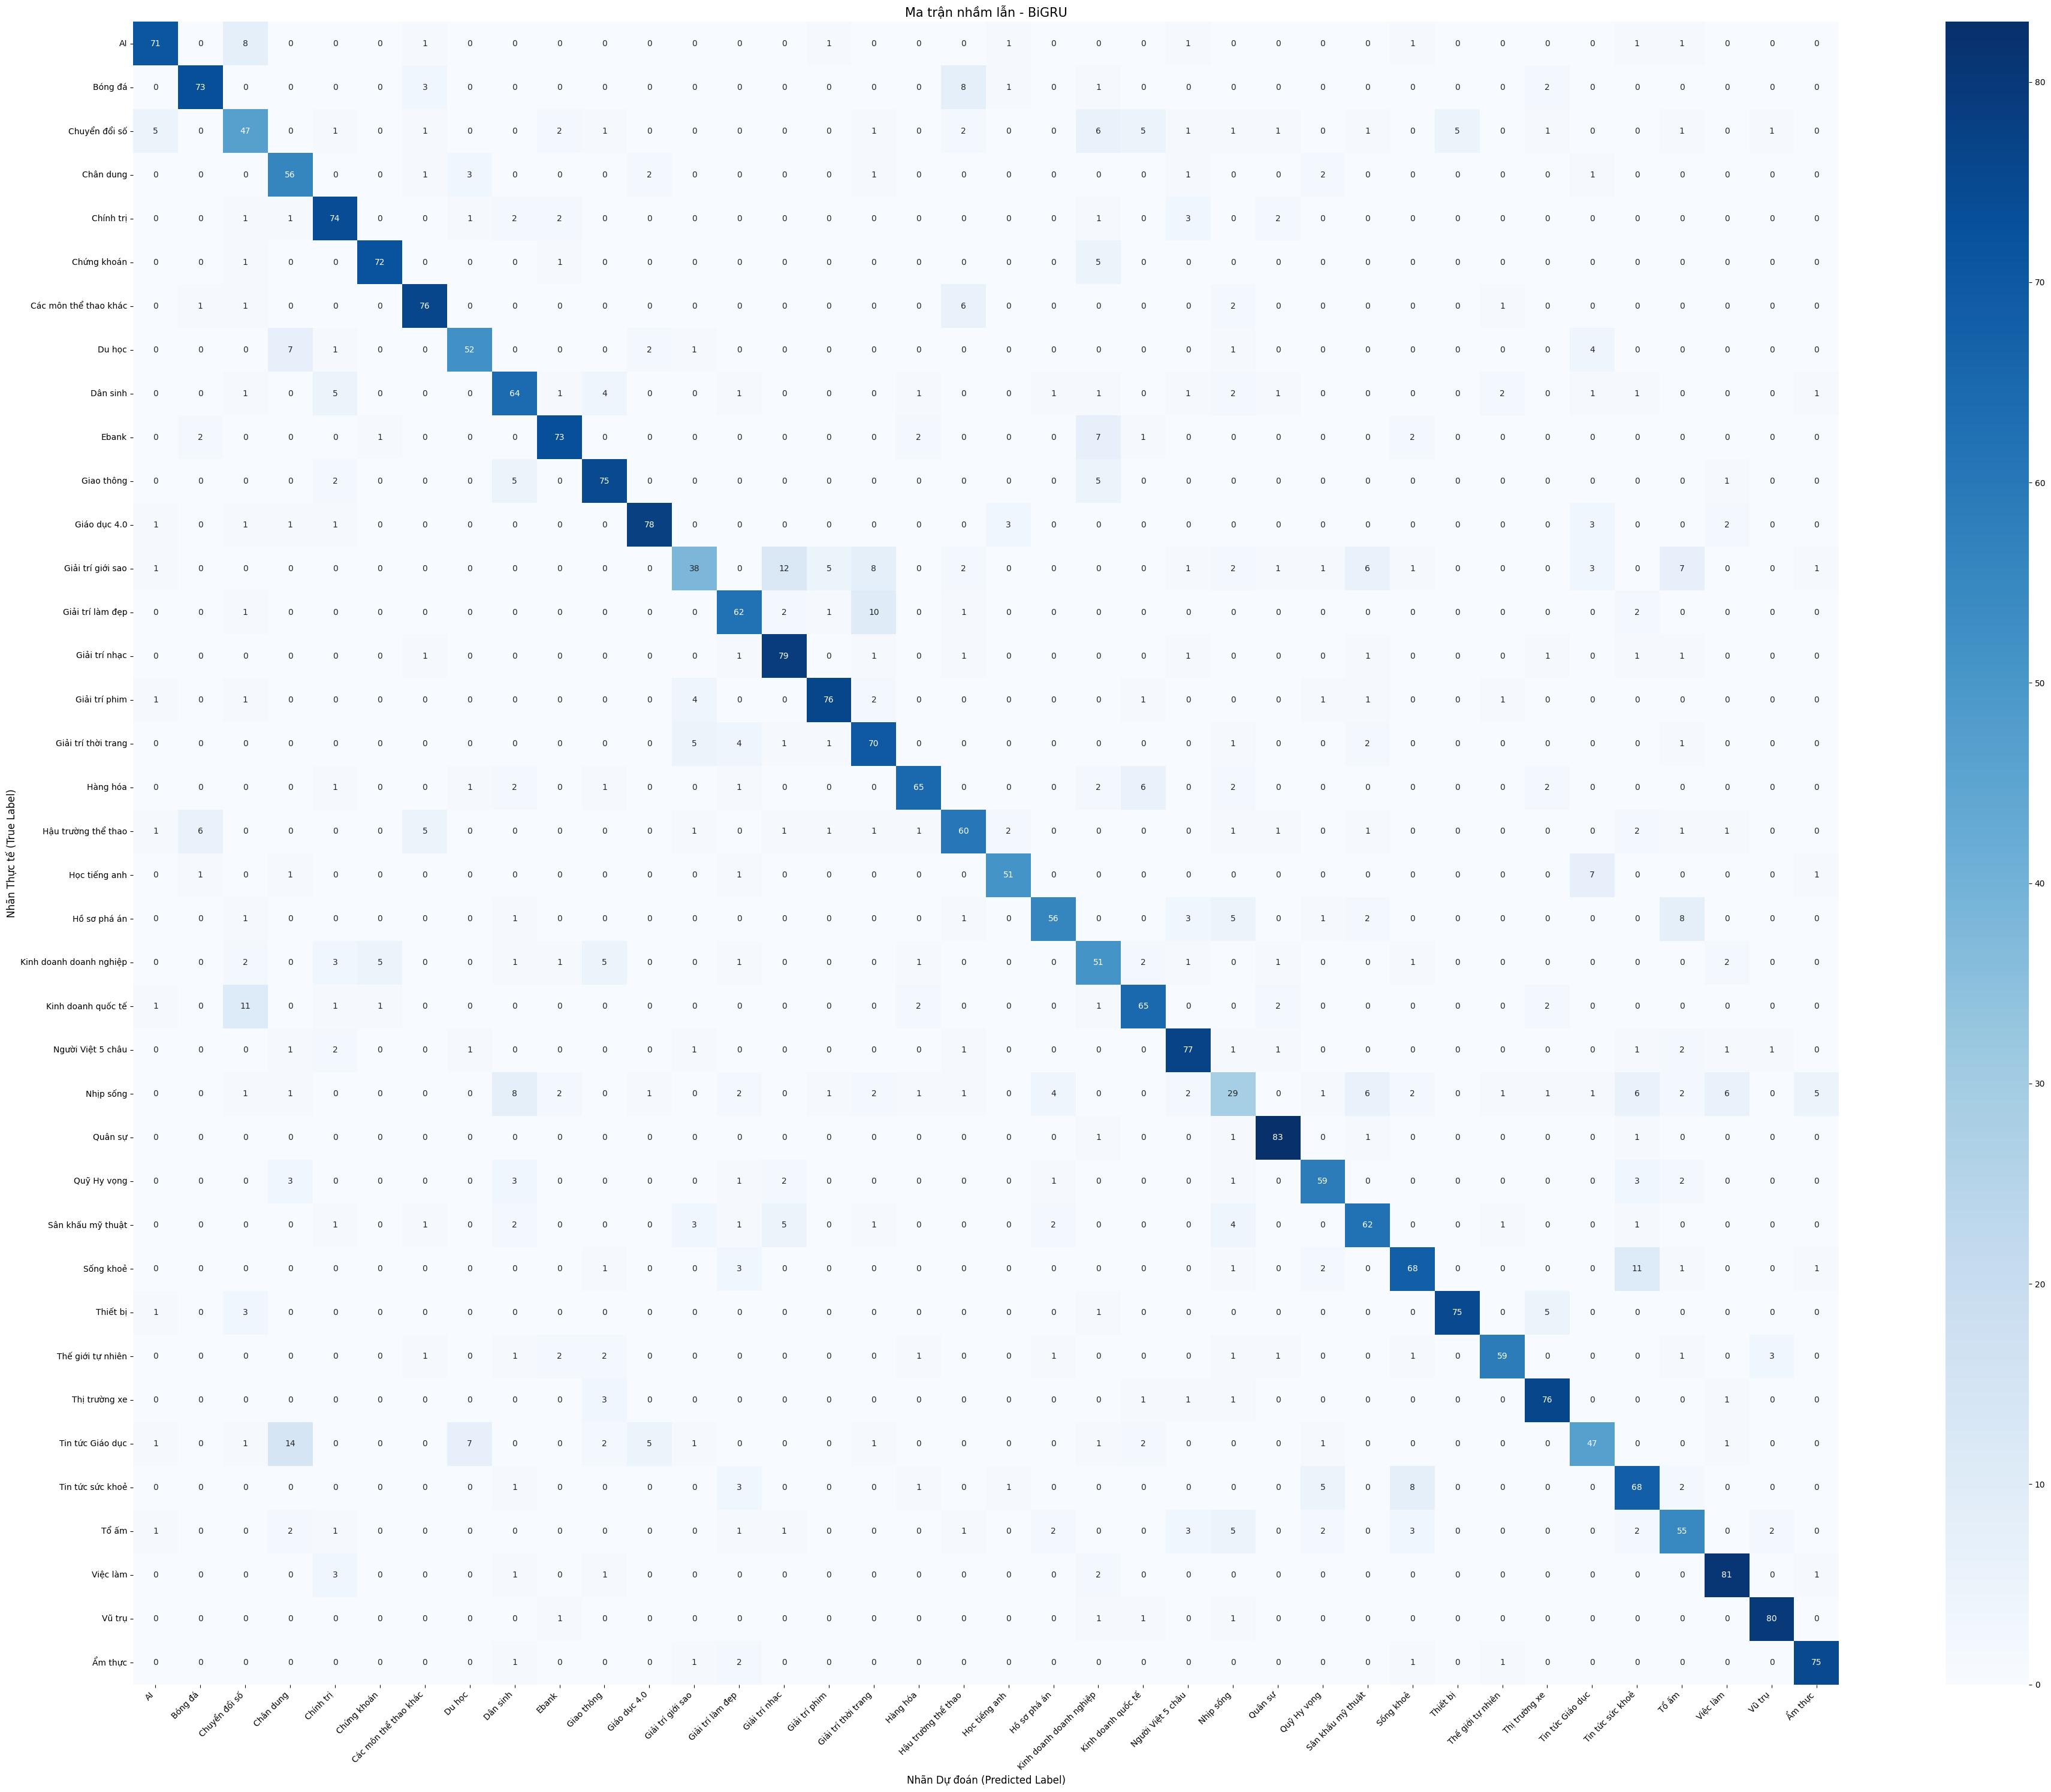

Đã lưu mô hình BiGRU vào: E:\LEARN_5\XuLyNgonNguTuNhien\project\models/bigru_model.keras

--- Hoàn thành huấn luyện và lưu mô hình ---


In [ ]:
# --- 4.2. BiGRU Model (với Word2Vec) ---
print("\n--- Mô hình BiGRU (với Word2Vec/FastText) ---")
bigru_model = create_bigru_model_w2v(
    vocab_size=vocab_size_tokenizer,
    embedding_dim_output=EMBEDDING_DIM_PRETRAINED,
    max_len=MAX_LEN,
    num_classes=num_classes,
    learning_rate=LEARNING_RATE,
    dropout_rate=DROPOUT_RATE,
    embedding_matrix_input=embedding_matrix,
    train_embeddings_flag=TRAIN_EMBEDDINGS
)
bigru_model.summary()

history_bigru = bigru_model.fit(
    X_train, y_train_cat,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_test, y_test_cat),
    class_weight=class_weights_dict,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

loss_bigru, accuracy_bigru = bigru_model.evaluate(X_test, y_test_cat, verbose=0)
print(f"Độ chính xác BiGRU (Accuracy): {accuracy_bigru:.4f}")
y_pred_proba_bigru = bigru_model.predict(X_test)
y_pred_classes_bigru = np.argmax(y_pred_proba_bigru, axis=1)

print("Báo cáo phân loại BiGRU (Classification Report):")
print(classification_report(y_test_classes_indices, y_pred_classes_bigru, labels=np.arange(num_classes), target_names=label_encoder.classes_, zero_division=0))
cm_bigru = confusion_matrix(y_test_classes_indices, y_pred_classes_bigru, labels=np.arange(num_classes))
plot_confusion_matrix_keras(cm_bigru, label_encoder.classes_, 'Ma trận nhầm lẫn - BiGRU (Word2Vec)')
bigru_model.save(BIGRU_MODEL_PATH)
print(f"Đã lưu mô hình BiGRU (Word2Vec) vào: {BIGRU_MODEL_PATH}")

print("\n--- Hoàn thành huấn luyện và lưu mô hình (Word2Vec) ---")


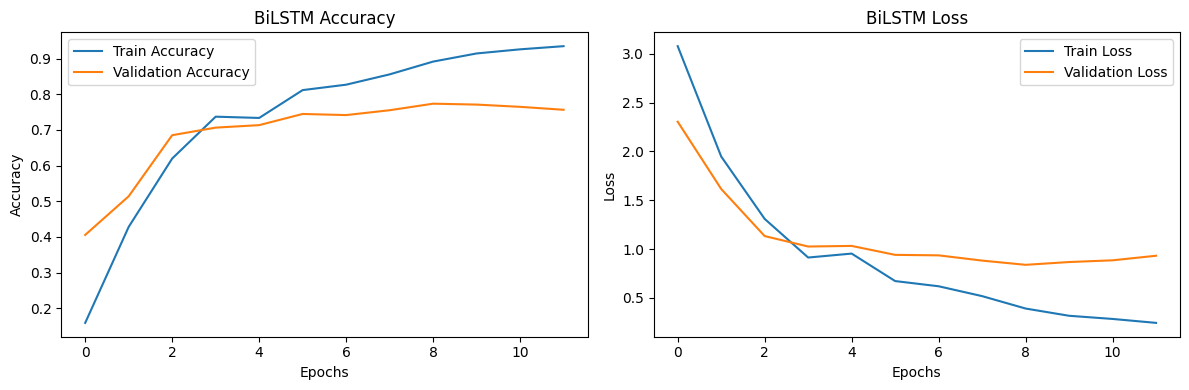

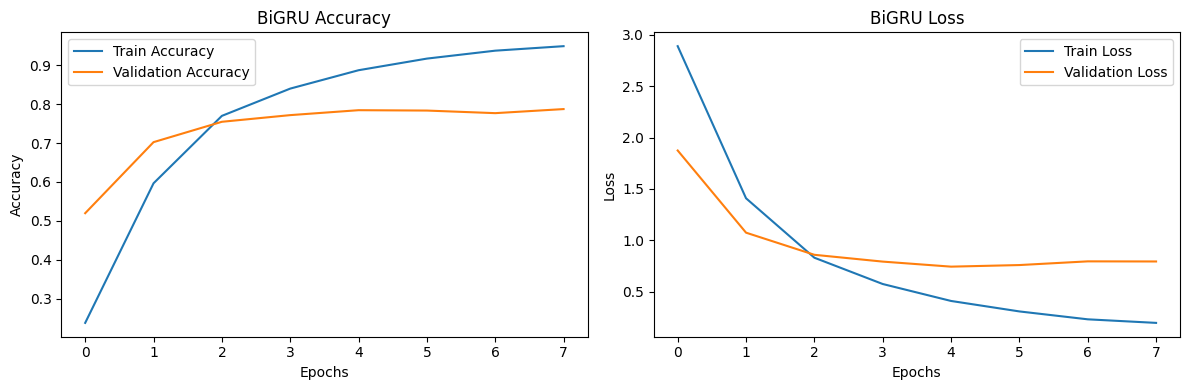

In [ ]:
# ... (plot_training_history giữ nguyên) ...
def plot_training_history(history, model_name): # Định nghĩa lại nếu chưa có
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{model_name} - Accuracy', fontsize=14)
    plt.xlabel('Epochs', fontsize=12)
    plt.ylabel('Accuracy', fontsize=12)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{model_name} - Loss', fontsize=14)
    plt.xlabel('Epochs', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

plot_training_history(history_bilstm, "BiLSTM (Word2Vec)")
plot_training_history(history_bigru, "BiGRU (Word2Vec)")